In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import ipywidgets as widgets
from IPython.display import display

In [ ]:
try:
    movies_df = pd.read_csv('/content/movies (1).csv')
    ratings_df = pd.read_csv('/content/ratings.csv')
except FileNotFoundError:
    print("Please make sure 'movies.csv' and 'ratings.csv' are in the correct directory.")
    movies_df = pd.DataFrame(columns=['movieId', 'title', 'genres'])
    ratings_df = pd.DataFrame(columns=['userId', 'movieId', 'rating', 'timestamp'])

print("Datasets loaded")
print("\nMovies:")
print(movies_df.head())
print("\nRatings:")
print(ratings_df.head())

In [ ]:
print(f"Shape of movies data: {movies_df.shape}")
print(f"Shape of ratings data: {ratings_df.shape}")

In [ ]:
df = pd.merge(ratings_df, movies_df, on='movieId')
print("\nMerged DataFrame Head:")
print(df.head())

In [ ]:
n_users = df['userId'].nunique()
n_movies = df['movieId'].nunique()
print(f"\nNumber of unique users: {n_users}")
print(f"Number of unique movies: {n_movies}")

In [ ]:
print("\nRating Distribution:")
print(df['rating'].describe())

In [ ]:
genres_df = movies_df['genres'].str.get_dummies(sep='|')
unique_genres = list(genres_df.columns)
print(f"\nFound {len(unique_genres)} unique genres.")

In [ ]:
print("\nTotal movies per genre:")
print(genres_df.sum().sort_values(ascending=False))

In [ ]:
genre_ratings = df.drop(['movieId', 'userId', 'timestamp', 'title'], axis=1)
genre_ratings = genre_ratings.join(genre_ratings['genres'].str.get_dummies(sep='|'))
genre_ratings = genre_ratings.drop('genres', axis=1)

In [ ]:
print("\nAverage rating per genre:")
avg_genre_rating = {}
for genre in unique_genres:
    avg_genre_rating[genre] = genre_ratings[genre_ratings[genre] == 1]['rating'].mean()

avg_rating_df = pd.Series(avg_genre_rating).sort_values(ascending=False)
print(avg_rating_df)

In [ ]:
def popularity_recommender(genre, min_reviews_threshold, N):
    genre_df = df[df['genres'].str.contains(genre, case=False, na=False)]
    if genre_df.empty:
        print(f"No movies found for the genre: {genre}")
        return
    movie_stats = genre_df.groupby('title').agg(
        Num_Reviews=('rating', 'count'),
        Average_Movie_Rating=('rating', 'mean')
    ).reset_index()
    qualified_movies = movie_stats[movie_stats['Num_Reviews'] >= min_reviews_threshold]
    top_n_movies = qualified_movies.sort_values(by='Average_Movie_Rating', ascending=False).head(N)
    top_n_movies = top_n_movies.reset_index(drop=True)
    top_n_movies.index = top_n_movies.index + 1
    top_n_movies.index.name = 'S.No'
    display(top_n_movies[['title', 'Average_Movie_Rating', 'Num_Reviews']].rename(columns={'title': 'Movie Title'}))

In [ ]:
print(f"Top 5 Popular Movies in 'Comedy' Genre (with at least 100 reviews)")
popularity_recommender(genre='Comedy', min_reviews_threshold=100, N=5)

In [ ]:
tfidf = TfidfVectorizer(stop_words='english')
movies_df['genres'] = movies_df['genres'].fillna('')
tfidf_matrix = tfidf.fit_transform(movies_df['genres'])
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
indices = pd.Series(movies_df.index, index=movies_df['title']).drop_duplicates()

In [ ]:
def content_based_recommender(movie_title, N):
    if movie_title not in indices:
        print(f"Movie '{movie_title}' not found in the dataset.")
        return
    idx = indices[movie_title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:N+1]
    movie_indices = [i[0] for i in sim_scores]
    recommended_movies = movies_df['title'].iloc[movie_indices].to_frame()
    recommended_movies = recommended_movies.reset_index(drop=True)
    recommended_movies.index = recommended_movies.index + 1
    recommended_movies.index.name = 'Sl.No'
    display(recommended_movies.rename(columns={'title': 'Movie Title'}))

In [ ]:
print(f"\nTop 5 Movies Similar to 'Toy Story (1995)' Based on Genre")
content_based_recommender(movie_title='Toy Story (1995)', N=5)

In [ ]:
user_movie_matrix = df.pivot_table(index='userId', columns='title', values='rating').fillna(0)
user_similarity = cosine_similarity(user_movie_matrix)
user_similarity_df = pd.DataFrame(user_similarity, index=user_movie_matrix.index, columns=user_movie_matrix.index)

In [ ]:
def collaborative_recommender(user_id, k, N):
    if user_id not in user_movie_matrix.index:
        print(f"User ID {user_id} not found.")
        return
    similar_users = user_similarity_df[user_id].sort_values(ascending=False).iloc[1:k+1]
    user_watched_movies = user_movie_matrix.loc[user_id][user_movie_matrix.loc[user_id] > 0].index
    recommendations = {}
    for similar_user_id, similarity_score in similar_users.items():
        similar_user_ratings = user_movie_matrix.loc[similar_user_id]
        unseen_movies = similar_user_ratings[similar_user_ratings > 0].index.difference(user_watched_movies)
        for movie in unseen_movies:
            if movie not in recommendations:
                recommendations[movie] = {'total_score': 0, 'total_similarity': 0}
            recommendations[movie]['total_score'] += similarity_score * similar_user_ratings[movie]
            recommendations[movie]['total_similarity'] += similarity_score
    if not recommendations:
        print("Could not find any new movies to recommend based on the given users.")
        return
    predicted_ratings = {movie: data['total_score'] / data['total_similarity'] for movie, data in recommendations.items()}
    top_n_movies = sorted(predicted_ratings.items(), key=lambda item: item[1], reverse=True)[:N]
    rec_df = pd.DataFrame(top_n_movies, columns=['Movie Title', 'Predicted Rating'])
    rec_df = rec_df.reset_index()
    rec_df['index'] = rec_df['index'] + 1
    rec_df = rec_df.rename(columns={'index': 'S.No'})
    display(rec_df[['S.No', 'Movie Title']])

In [ ]:
print(f"\nTop 5 Movie Recommendations for User ID 1 (based on 100 similar users)")
collaborative_recommender(user_id=1, k=100, N=5)

In [ ]:
print("\n### Popularity-Based Recommender GUI ###")
style = {'description_width': 'initial'}
popularity_ui = widgets.interactive(
    popularity_recommender,
    genre=widgets.Dropdown(options=sorted(unique_genres), description='Select Genre:', style=style),
    min_reviews_threshold=widgets.IntSlider(min=50, max=500, step=10, value=100, description='Min Reviews Threshold:', style=style),
    N=widgets.IntSlider(min=1, max=10, step=1, value=5, description='Num Recommendations:', style=style)
)
display(popularity_ui)

print("\n### Content-Based Recommender GUI ###")
content_ui = widgets.interactive(
    content_based_recommender,
    movie_title=widgets.Dropdown(options=sorted(movies_df['title'].tolist()), description='Select Movie:', style=style),
    N=widgets.IntSlider(min=1, max=10, step=1, value=5, description='Num Recommendations:', style=style)
)
display(content_ui)

print("\n### Collaborative Filtering Recommender GUI ###")
collab_ui = widgets.interactive(
    collaborative_recommender,
    user_id=widgets.Dropdown(options=sorted(ratings_df['userId'].unique().tolist()), description='Select UserID:', style=style),
    k=widgets.IntSlider(min=10, max=200, step=10, value=100, description='Num Similar Users (k):', style=style),
    N=widgets.IntSlider(min=1, max=10, step=1, value=5, description='Num Recommendations:', style=style)
)
display(collab_ui)

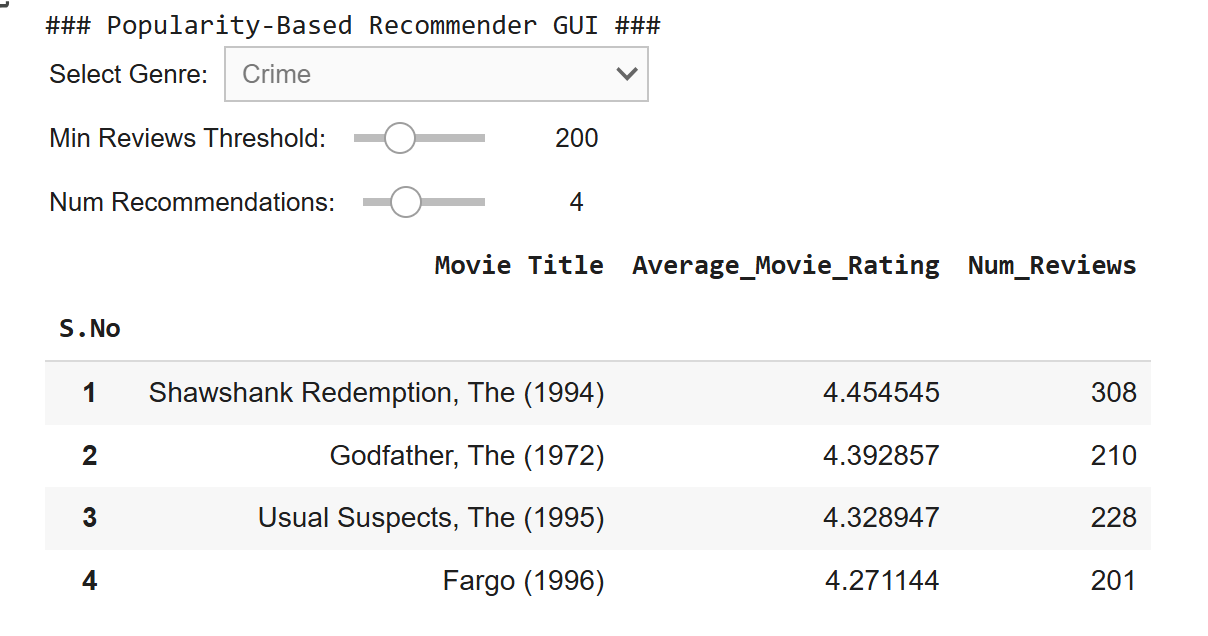

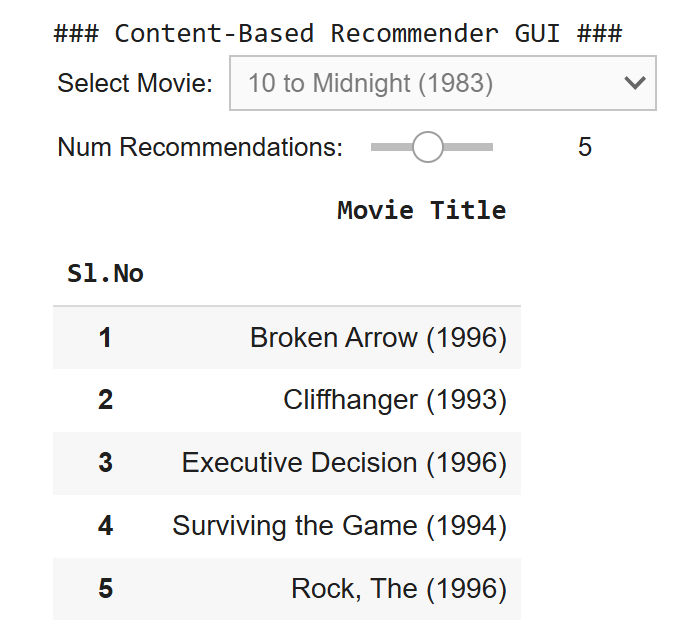

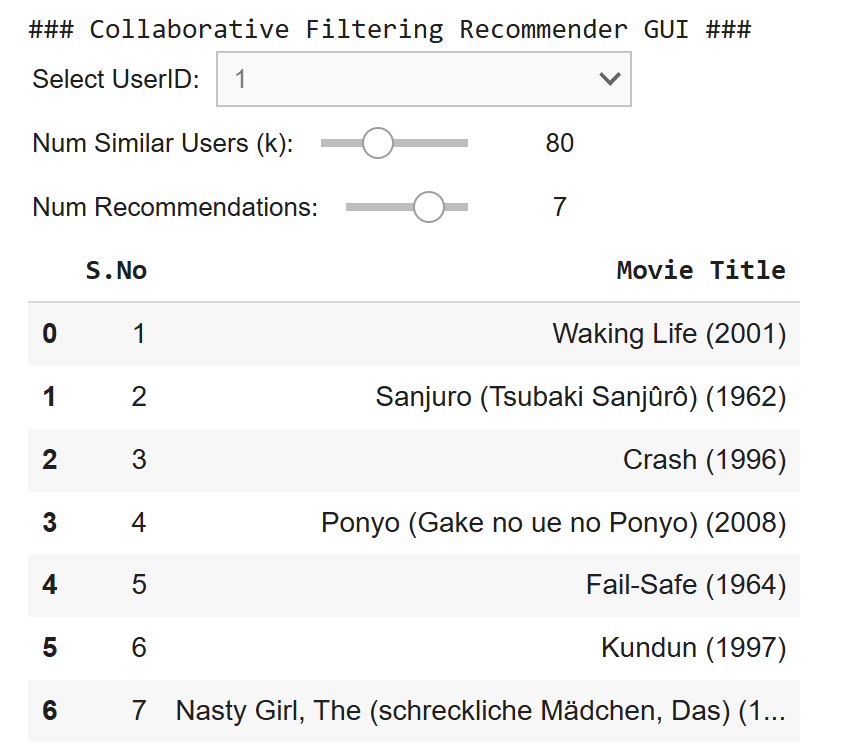

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install nbstripout

notebook_path = '/content/drive/MyDrive/Colab Notebooks/Movie_Recommendation_System.ipynb'
!nbstripout "$notebook_path"

!nbstripout '/content/drive/MyDrive/movies (1).csv'
!nbstripout '/content/drive/MyDrive/ratings.csv'

In [ ]:
from google.colab import files

files.download('/content/drive/MyDrive/Colab Notebooks/Movie_Recommendation_System.ipynb')

files.download('/content/drive/MyDrive/movies (1).csv')
files.download('/content/drive/MyDrive/ratings.csv')